In [1]:
import os
from typing import List

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split

DATADIR = os.path.join("data", "auto-insurance-fall-2017")

## Preprocessing

### 1. Data preview

In [2]:
ds = pd.read_csv(os.path.join(DATADIR, "train_auto.csv"))
ds.head()

,INDEX,TARGET_FLAG,TARGET_AMT,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,...,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,1,0,0.0,0,60.0,0,11.0,"$67,349",No,$0,...,"$14,230",11,Minivan,yes,"$4,461",2,No,3,18.0,Highly Urban/ Urban
1,2,0,0.0,0,43.0,0,11.0,"$91,449",No,"$257,252",...,"$14,940",1,Minivan,yes,$0,0,No,0,1.0,Highly Urban/ Urban
2,4,0,0.0,0,35.0,1,10.0,"$16,039",No,"$124,191",...,"$4,010",4,z_SUV,no,"$38,690",2,No,3,10.0,Highly Urban/ Urban
3,5,0,0.0,0,51.0,0,14.0,NaN,No,"$306,251",...,"$15,440",7,Minivan,yes,$0,0,No,0,6.0,Highly Urban/ Urban
4,6,0,0.0,0,50.0,0,NaN,"$114,986",No,"$243,925",...,"$18,000",1,z_SUV,no,"$19,217",2,Yes,3,17.0,Highly Urban/ Urban


In [3]:
print("Number of non-null values:\n", ds.count())

Number of non-null values:
 INDEX          8161
TARGET_FLAG    8161
TARGET_AMT     8161
KIDSDRIV       8161
AGE            8155
HOMEKIDS       8161
YOJ            7707
INCOME         7716
PARENT1        8161
HOME_VAL       7697
MSTATUS        8161
SEX            8161
EDUCATION      8161
JOB            7635
TRAVTIME       8161
CAR_USE        8161
BLUEBOOK       8161
TIF            8161
CAR_TYPE       8161
RED_CAR        8161
OLDCLAIM       8161
CLM_FREQ       8161
REVOKED        8161
MVR_PTS        8161
CAR_AGE        7651
URBANICITY     8161
dtype: int64


### 2. Data clean-up and encoding

In [4]:
numeric_cols = ["KIDSDRIV", "AGE", "HOMEKIDS", "YOJ", "INCOME", "HOME_VAL",
                "TRAVTIME", "BLUEBOOK", "TIF", "OLDCLAIM", "CLM_FREQ", 
                "MVR_PTS", "CAR_AGE"]
bool_cols = ["PARENT1", "MSTATUS", "SEX", "URBANICITY", "CAR_USE", "REVOKED"]
cat_cols = ["EDUCATION", "JOB", "CAR_TYPE"]
unused_cols = ["INDEX", "TARGET_AMT", "RED_CAR"]

clean = ds.copy()
clean.drop(unused_cols, axis="columns", inplace=True)

# Remove currency on numerics
clean[numeric_cols] = clean[numeric_cols].replace("[\$,]", "", regex=True)
# Convert numerics to floating point
clean[numeric_cols] = clean[numeric_cols].astype(float)

# Replace boolean categories by a one-hot encoding (0 and 1 labels)
clean = pd.concat((clean, pd.get_dummies(clean[bool_cols], drop_first=True)), axis="columns")
# Remove original columns
clean.drop(bool_cols, axis="columns", inplace=True)
    
# 'Education' can be represented with an ordinal encoding:
oe = OrdinalEncoder(categories=[["<High School", "z_High School", "Bachelors", "Masters", "PhD"]])
clean["EDUCATION"] = oe.fit_transform(clean[["EDUCATION"]])

# 'JOB' has missing values: replace with "Unknown"
clean["JOB"].fillna("Unknown", inplace=True)

For the two remaining categorical features ('JOB', 'CAR_TYPE'), there is no logical order to the values giving a simple label encoding like for 'EDUCATION'. As there are not too many categories in these two features we can first try to use a one-hot encoding.

In [5]:
# Replace categorical features by a one-hot encoding (0 and 1 labels)
clean = pd.concat((clean, pd.get_dummies(clean[["JOB", "CAR_TYPE"]], drop_first=True)), axis="columns")
# Remove original columns
clean.drop(["JOB", "CAR_TYPE"], axis="columns", inplace=True)

# Label encoding
# clean["JOB"] = LabelEncoder().fit_transform(clean["JOB"])
# clean["CAR_TYPE"] = LabelEncoder().fit_transform(clean["CAR_TYPE"])

clean.head()

,TARGET_FLAG,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,HOME_VAL,EDUCATION,TRAVTIME,BLUEBOOK,...,JOB_Manager,JOB_Professional,JOB_Student,JOB_Unknown,JOB_z_Blue Collar,CAR_TYPE_Panel Truck,CAR_TYPE_Pickup,CAR_TYPE_Sports Car,CAR_TYPE_Van,CAR_TYPE_z_SUV
0,0,0.0,60.0,0.0,11.0,67349.0,0.0,4.0,14.0,14230.0,...,0,1,0,0,0,0,0,0,0,0
1,0,0.0,43.0,0.0,11.0,91449.0,257252.0,1.0,22.0,14940.0,...,0,0,0,0,1,0,0,0,0,0
2,0,0.0,35.0,1.0,10.0,16039.0,124191.0,1.0,5.0,4010.0,...,0,0,0,0,0,0,0,0,0,1
3,0,0.0,51.0,0.0,14.0,NaN,306251.0,0.0,32.0,15440.0,...,0,0,0,0,1,0,0,0,0,0
4,0,0.0,50.0,0.0,NaN,114986.0,243925.0,4.0,36.0,18000.0,...,0,0,0,0,0,0,0,0,0,1


### 3. Scaling

Scale numeric values to have zero mean and unit variance. Scaling transform is computed only on the training set.

In [6]:
X = clean.drop("TARGET_FLAG", axis="columns") # features
y = clean["TARGET_FLAG"] # labels

# Split the dataset between a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

# Normalize each feature
scaled_feat = X.columns # scale all columns or only numeric features ?
scaler = StandardScaler()
scaler.fit(X_train[scaled_feat])
X_train[scaled_feat] = scaler.transform(X_train[scaled_feat])
X_test[scaled_feat] = scaler.transform(X_test[scaled_feat])

# the standard scaler ignores NaNs. We replace NaNs by the mean value of each feature
# which is now 0 since we standardized it.
X_train = X_train.fillna(0.)
X_test = X_test.fillna(0.)


## Fitting models

In [20]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, accuracy_score
from sklearn.pipeline import make_pipeline

## 1. SVM

In [22]:
from sklearn.svm import SVC

clf = make_pipeline(StandardScaler(), SVC(kernel="rbf", gamma="scale", probability=True))
clf.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(probability=True))])

In [23]:
y_pred = clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.6511627906976745, 0.3971631205673759, 0.4933920704845816, None)

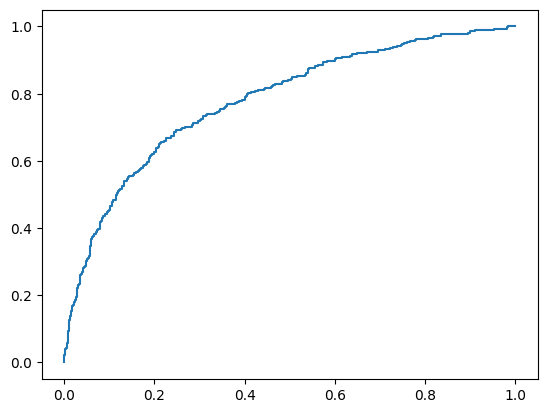

In [24]:
fpr, tpr, _ = roc_curve(y_test, clf.decision_function(X_test))
plt.plot(fpr, tpr)
plt.show()

In [25]:
accuracy_score(y_test, y_pred)

0.7887323943661971

## 2. Knn

In [26]:
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier

clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=10)

In [27]:
y_pred = clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.6170212765957447, 0.27423167848699764, 0.3797054009819967, None)

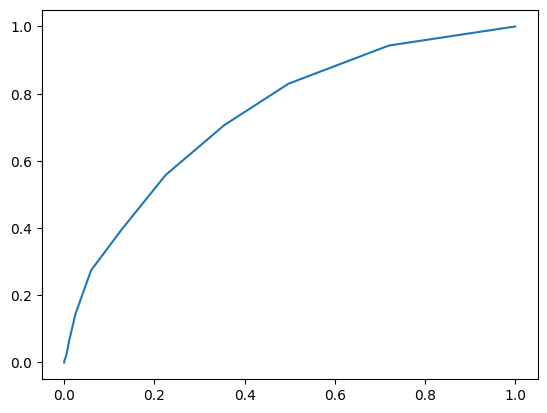

In [28]:
y_scores = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr)
plt.show()

In [29]:
accuracy_score(y_test, y_pred)

0.7679118187385181

## 3. Decision trees and Random forest

In [30]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, random_state=0)

In [31]:
y_pred = clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.6974358974358974, 0.3215130023640662, 0.44012944983818775, None)

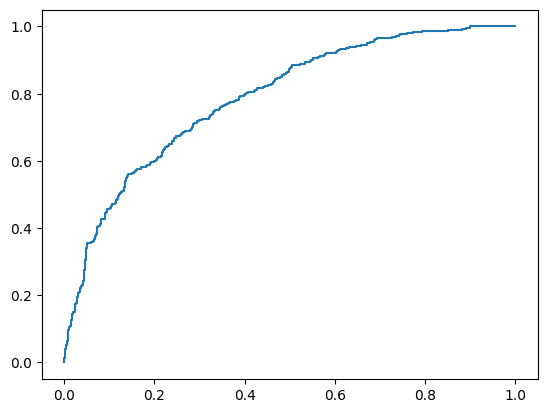

In [32]:
y_scores = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr)
plt.show()

In [33]:
accuracy_score(y_test, y_pred)

0.7881200244947949

## 4. MLP

In [34]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=0, max_iter=400, learning_rate_init=.001, 
                    solver="adam", hidden_layer_sizes=(512, 128), activation="relu")
clf.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=(512, 128), max_iter=400, random_state=0)

In [35]:
y_pred = clf.predict(X_test)
precision_recall_fscore_support(y_test, y_pred, average='binary')

(0.5064599483204134, 0.46335697399527187, 0.4839506172839506, None)

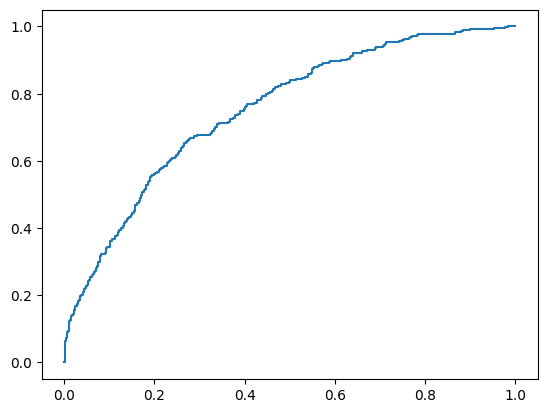

In [36]:
y_scores = clf.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_scores[:, 1])
plt.plot(fpr, tpr)
plt.show()

In [37]:
accuracy_score(y_test, y_pred)

0.7440293937538273

## Model selection